<h1>Lesson 4. Model selection: Car mileage</h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/%22real_time_display%22_of_mileage_%28%22mpg%22%29_on_Honda_Insight.png/320px-%22real_time_display%22_of_mileage_%28%22mpg%22%29_on_Honda_Insight.png" style="height:200px;">
  
<p>In this exercise you will predict car mileage based on its properties. The data is taken from <a href="http://www-bcf.usc.edu/~gareth/ISL/">ISLR website</a>, but requires few transformations to make it usable for model building. These transformations will include: missing value imputation and normalizing the variables. </p>

<p>This dataset contains 392 car entries with following features:</p>
<ul>
<li>mpg miles per gallon (what we are trying to predict)</li>
<li>cylinders Number of cylinders between 4 and 8</li>
<li>displacement Engine displacement (cu. inches)</li>
<li>horsepower Engine horsepower</li>
<li>weight Vehicle weight (lbs.)</li>
<li>acceleration Time to accelerate from 0 to 60 mph (sec.)</li>
<li>year Model year (modulo 100)</li>
<li>origin Origin of car (1. American, 2. European, 3. Japanese)</li>
<li>name Vehicle name</ul>
</ul>


In [1]:
library(ggplot2)
library(magrittr)
library(xtable)
library(MASS)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
chevrolet chevelle malibu 1,18,8,307,130,3504,12.0,70,1
buick skylark 320 2,15,8,350,165,3693,11.5,70,1
plymouth satellite 3,18,8,318,150,3436,11.0,70,1
amc rebel sst 4,16,8,304,150,3433,12.0,70,1
ford torino 5,17,8,302,140,3449,10.5,70,1
ford galaxie 500 6,15,8,429,198,4341,10.0,70,1


'data.frame':	397 obs. of  8 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : int  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : int  3504 3693 3436 3433 3449 4341 4354 4312 4425 3850 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : int  1 1 1 1 1 1 1 1 1 1 ...


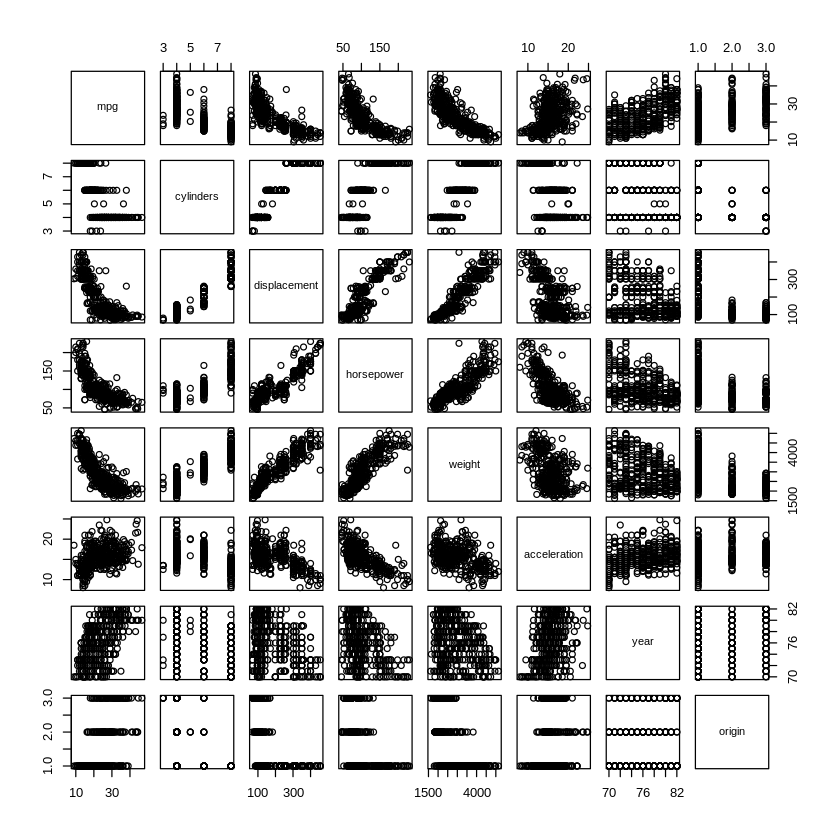

In [2]:
# Load the data
auto_url = "http://www-bcf.usc.edu/~gareth/ISL/Auto.csv"
auto = read.csv(auto_url, na.strings="?")
# Note that you can also obtain the data from ISLR package:
# library(help = ISLR)
# We will name the rows using the 'name' column. 
# However, assigning the column to rows, will throw an error, because they are not unique.
#
# Let's make them unique by combining it with the row number:
row.names(auto) = paste(auto$name, 1:nrow(auto))
# After this operation, you can delete the name from our dataset:
auto$name <- NULL

head(auto)
str(auto)
plot(auto)

<h3>Q.1. Write a command that will calculate the number of missing values in this dataset</h3>

In [3]:
# Command(s)
features <- colnames(auto)
sapply(X = features, FUN = function(x) {sum(is.na(auto[,colnames(auto) == x]))})

mpg    cylinders displacement   horsepower       weight acceleration 
           0            0            0            5            0            0 
        year       origin 
           0            0

<h3>Q.2. Write a command that will only show the rows with missing values. Can you comment on why the values might be missing (e.g. excessive prevalence of specific feature)?</h3>

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
ford pinto 33,25.0,4,98,NA,2046,19.0,71,1
ford maverick 127,21.0,6,200,NA,2875,17.0,74,1
renault lecar deluxe 331,40.9,4,85,NA,1835,17.3,80,2
ford mustang cobra 337,23.6,4,140,NA,2905,14.3,80,1
renault 18i 355,34.5,4,100,NA,2320,15.8,81,2


Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”

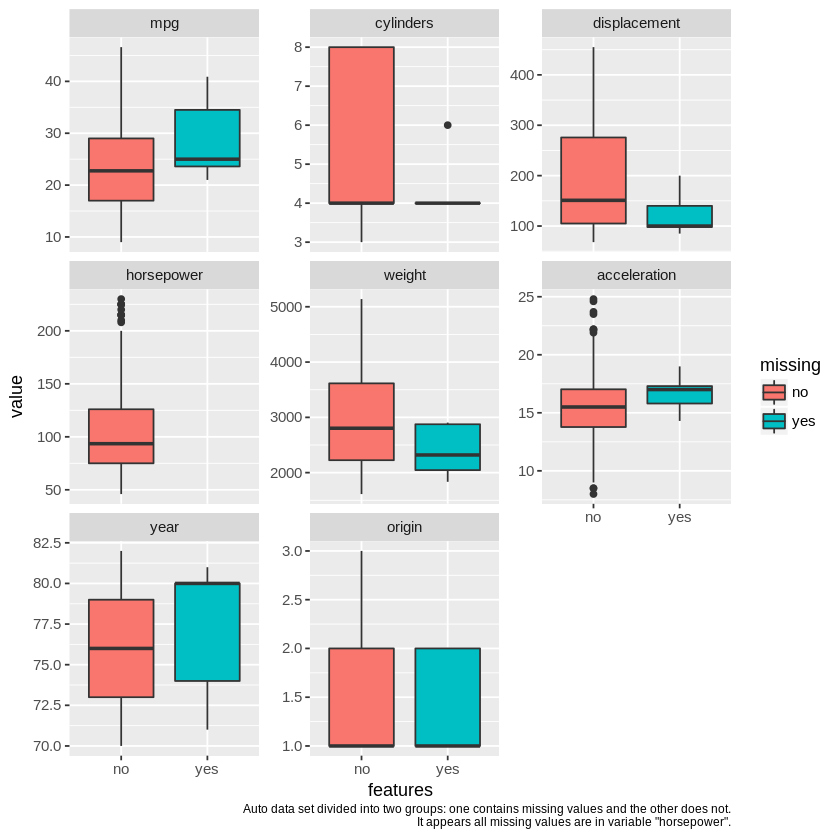

In [4]:
# Command:
#rows with missing values ('NA')
rows_with_NA <- auto[is.na(auto$horsepower),]
rows_with_NA

# diagnostic boxplots
ggplot2::ggplot(data= auto %>% dplyr::mutate(., missing = ifelse(is.na(auto$horsepower), "yes", "no")) %>% 
       tidyr::gather(data = ., key = features,
                     features = mpg:origin,
                     value = value,
                     factor_key = TRUE,
                     na.rm = FALSE)) +
    ggplot2::geom_boxplot(aes(x=missing, y=value, fill=missing)) +
    ggplot2::facet_wrap(facets = ~ features, scales = "free_y") +
    ggplot2::labs(x = "features",
                  legend = "missing values",
                  caption = "Auto data set divided into two groups: one contains missing values and the other does not.
It appears all missing values are in variable \"horsepower\".") +
    ggplot2::theme(plot.caption = element_text(size = 7))

> **ANSWER Q2:**
> The data set contains 5 missing values, all in variable _horsepower_.

<h3>Q.3. Impute the missing values using median for the column. Given answer to Q.2, is this a good approach to fix the missing value problem?</h3>

In [5]:
# Command(s):
hp.imputed <- ifelse(is.na(auto$horsepower),
                     median(x = auto$horsepower, na.rm = TRUE),
                     auto$horsepower)

auto$hp.imputed <- hp.imputed

# sanity check
auto[which(!(auto$horsepower %in% auto$hp.imputed)),] 
auto$horsepower <- NULL #remove original horsepower column
head(auto)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,hp.imputed
ford pinto 33,25.0,4,98,NA,2046,19.0,71,1,93.5
ford maverick 127,21.0,6,200,NA,2875,17.0,74,1,93.5
renault lecar deluxe 331,40.9,4,85,NA,1835,17.3,80,2,93.5
ford mustang cobra 337,23.6,4,140,NA,2905,14.3,80,1,93.5
renault 18i 355,34.5,4,100,NA,2320,15.8,81,2,93.5


,mpg,cylinders,displacement,weight,acceleration,year,origin,hp.imputed
chevrolet chevelle malibu 1,18,8,307,3504,12.0,70,1,130
buick skylark 320 2,15,8,350,3693,11.5,70,1,165
plymouth satellite 3,18,8,318,3436,11.0,70,1,150
amc rebel sst 4,16,8,304,3433,12.0,70,1,150
ford torino 5,17,8,302,3449,10.5,70,1,140
ford galaxie 500 6,15,8,429,4341,10.0,70,1,198


> **ANSWER Q3:**  
> It does make sense to impute missing _horsepower_ values using the median. As can be seen in the "cylinder" boxplot in Q2, the median cylinder for the entire auto data set is 4. Since cylinder count determines a car's horsepower, imputing on the median is a reasonable choice.

<h3>Q.4. Create the contrast variables (origin.American, origin.European) for the origin of the car. Remove the numerical 'origin' column from the data.frame. Why didn't we create a variable for 'origin.Japanese'?</h3>

In [6]:
# Commands:
# Origin of car (1. American, 2. European, 3. Japanese)
auto$origin.American <- ifelse(auto$origin == 1, 1, 0)
auto$origin.European <- ifelse(auto$origin == 2, 1, 0)

# Remove origin
auto$origin <- NULL
tail(auto)

,mpg,cylinders,displacement,weight,acceleration,year,hp.imputed,origin.American,origin.European
chevrolet camaro 392,27,4,151,2950,17.3,82,90,1,0
ford mustang gl 393,27,4,140,2790,15.6,82,86,1,0
vw pickup 394,44,4,97,2130,24.6,82,52,0,1
dodge rampage 395,32,4,135,2295,11.6,82,84,1,0
ford ranger 396,28,4,120,2625,18.6,82,79,1,0
chevy s-10 397,31,4,119,2720,19.4,82,82,1,0


> **ANSWER Q4:**
> The number of levels/contrasts needed to represent k categories is k-1. Thus, in our re-coded _origin_ variable...  
>
| | origin.American | origin.European |  
 |-:|--:|---:|
 |American|1|0|
 |European|0|1|
 |Japanese|0|0|
 

<h3>Q.5. Develop a model that predicts mpg using all the available features in the data.frame. Summarize it and comment on its quality. </h3>

In [7]:
# Develop the model 
modQ5 <- lm(formula = mpg ~., data = auto)
summary(modQ5)


Call:
lm(formula = mpg ~ ., data = auto)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9229 -2.0778 -0.0884  1.9425 13.3373 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -16.438307   4.627592  -3.552 0.000429 ***
cylinders        -0.450175   0.319805  -1.408 0.160033    
displacement      0.023835   0.007632   3.123 0.001924 ** 
weight           -0.006943   0.000644 -10.781  < 2e-16 ***
acceleration      0.107179   0.096651   1.109 0.268147    
year              0.787844   0.051120  15.412  < 2e-16 ***
hp.imputed       -0.012995   0.013406  -0.969 0.332967    
origin.American  -2.807050   0.547333  -5.129 4.62e-07 ***
origin.European  -0.052948   0.558932  -0.095 0.924578    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.306 on 388 degrees of freedom
Multiple R-squared:  0.8252,	Adjusted R-squared:  0.8216 
F-statistic: 228.9 on 8 and 388 DF,  p-value: < 2.2e-16


> **ANSWER Q5:**  
> The multivariate linear regression model reveals at least one feature is associated with _mpg_ (F-statistics = 224.5, with p-value < 2.2e-16).

<h3>Q.6. Show histogram of engine displacement to reveal its non-normal distribution. Calculate optimal 'lambda' value for this feature and apply it to displacement to create 'displacement.boxcox' feature. Plot this new feature to see whether it is normally distributed.</h3>

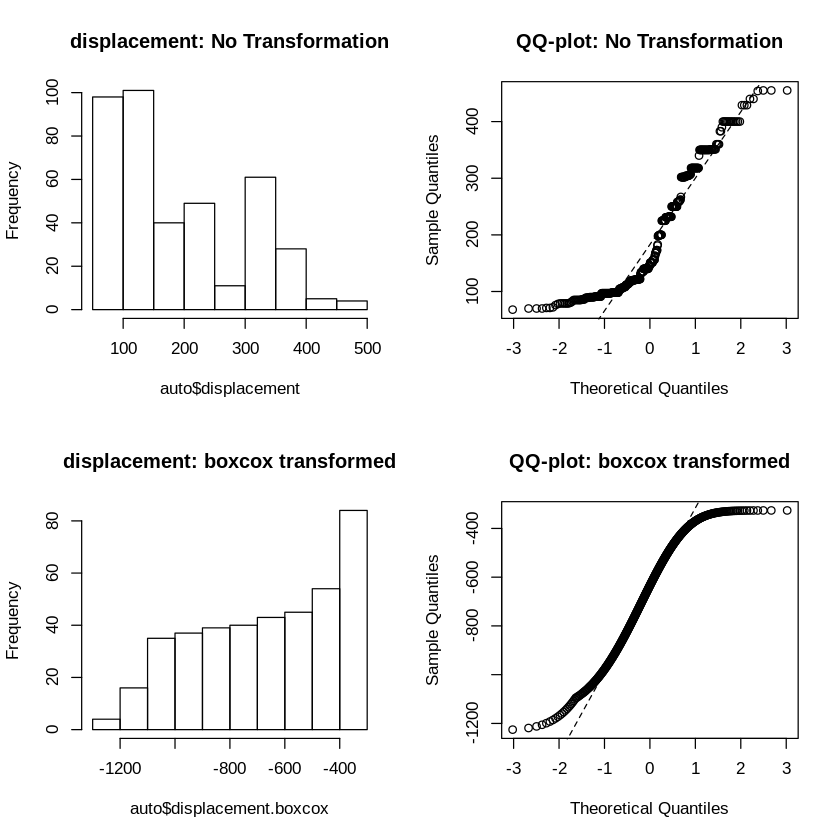

In [8]:
# Histogram of engine displacement
par(mfrow = c(2,2))
hist(auto$displacement, main = "displacement: No Transformation")
qqnorm(auto$displacement, main = "QQ-plot: No Transformation")
qqline(auto$displacement, lty=2)

# Calculate optimal 'lambda'
bc <- MASS::boxcox(object = modQ5,
                   lambda = seq(from = -5, to = 5, length.out = nrow(auto)),
                   plot = FALSE)
lambda <- bc$x[which.max(bc$y)]
# lambda

# Create 'displacement.boxcox'
auto$displacement.boxcox <- bc$y
auto$displacement <- NULL
# head(auto)

# Plot histogram of this new feature to reveal normal-like distribution
hist(auto$displacement.boxcox, main = "displacement: boxcox transformed")
qqnorm(auto$displacement.boxcox, main = "QQ-plot: boxcox transformed")
qqline(auto$displacement.boxcox, lty=2)

> **ANSWER Q6:**  
> $\lambda_{optimmal}=-0.3535$  
> It appears boxcox transformation makes the variable _displacement_ take more of a normal distribution. However, the transformed version is heavily left-skewed (histogram, QQ-plot)

<h3>Q.7. Recalculate the model to predict mpg with the new feature and comment on its performance in comparison to the original model.</h3>

In [9]:
# Calculate then new model
modQ7 <- lm(formula = mpg ~., data = auto)
compare <- rbind(Q5=broom::glance(modQ5), Q7=broom::glance(modQ7))
compare <- compare[, -c(1,6:11)]
colnames(compare) <- c("adj R^2", "sigma", "F-statistic", "p-value")
compare
# Comment on its performance
#

,adj R^2,sigma,F-statistic,p-value
Q5,0.8215682,3.305713,228.9169,8.237085e-142
Q7,0.8336023,3.192292,248.9800,1.124904e-147


> **ANSWER Q7**  
> A comparison of model metrics from Q5 and Q7 is tabulated above, where sigma is Residual Standard Error and other columns are self-explanatory. Overall, both models are highly similar, as both indicate that there is at least one predictor variable that is associated with _mpg_. The Q7 model (with boxcox transformation) is slightly more robust (larger adjusted R^2 and F-statistic, smaller sigma and p-value).

<h3>Q.8. What is the mean and standard deviation for all the features?</h3>

In [10]:
# Command(s) that shows mean for all the features
features <- colnames(auto)
features.mean <- sapply(X = features, FUN = function(x) {mean(auto[,colnames(auto) == x])})

# Command(s) that shows standard deviation for all the features
features.sd <- sapply(X = features, FUN = function(x) {sd(auto[,colnames(auto) == x])})

# sanity check
round(cbind(features.mean, features.sd),2)

,features.mean,features.sd
mpg,23.52,7.83
cylinders,5.46,1.70
weight,2970.26,847.90
acceleration,15.56,2.75
year,75.99,3.69
hp.imputed,104.33,38.27
origin.American,0.62,0.48
origin.European,0.18,0.38
displacement.boxcox,-666.30,258.34


> **ANSWER Q8**  
> The mean and standard deviation for each feature is tabulated above. It is unclear to me how to interpret the mean and SD of a categorical variable such as _origin.American, origina.European_, or _cylinders_. However, the question asks to calculate those statistics for all features; so I did!

<h3>Q.9. Center all the features, so that their mean is 0 and scale them, so that their standard deviation is 1. Recalculate the model, comment on its performance.</h3>

In [11]:
###### Center and scale

### NOTE: centering around mean, as described in van den Berg et al. (BMC Genomics 2006, 7:142)
auto_centered <- sapply(X = colnames(auto),
                        FUN = function(x) {auto[,colnames(auto) == x] - features.mean[names(features.mean) == x]})
auto_centered <- as.data.frame(auto_centered)

### NOTE: using "auto-scaling" method as described in van den Berg et al. (BMC Genomics 2006, 7:142)
auto_centered_scaled <- sapply(X = colnames(auto_centered),
                               FUN = function(x)
                               {auto_centered[,colnames(auto_centered) == x] / features.sd[names(features.sd) == x]})
auto_centered_scaled <- as.data.frame(auto_centered_scaled)
rownames(auto_centered_scaled) <- rownames(auto)

# sanity checks
# head(auto)
# head(auto_centered)
# head(auto_centered_scaled)

# Recalculate the model
modQ9 <- lm(formula = mpg ~ ., data = auto_centered_scaled)
summary(modQ9)

# Comment on its performance
compare <- rbind(Q5=broom::glance(modQ5), Q7=broom::glance(modQ7), Q9=broom::glance(modQ9))
compare <- compare[, -c(1,6:11)]
colnames(compare) <- c("adj R^2", "sigma", "F-statistic", "p-value")
compare


Call:
lm(formula = mpg ~ ., data = auto_centered_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.07382 -0.24128 -0.00974  0.21491  1.66331 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -2.621e-16  2.047e-02   0.000    1.000    
cylinders            5.218e-02  5.105e-02   1.022    0.307    
weight              -5.825e-01  6.255e-02  -9.313  < 2e-16 ***
acceleration         1.830e-02  3.264e-02   0.561    0.575    
year                 3.617e-01  2.314e-02  15.630  < 2e-16 ***
hp.imputed          -9.162e-02  6.218e-02  -1.473    0.141    
origin.American     -1.517e-01  3.124e-02  -4.856 1.74e-06 ***
origin.European      1.504e-03  2.632e-02   0.057    0.954    
displacement.boxcox -1.335e-01  2.151e-02  -6.206 1.39e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4079 on 388 degrees of freedom
Multiple R-squared:  0.837,	Adjusted R-squared:  0.8336 
F-statisti

,adj R^2,sigma,F-statistic,p-value
Q5,0.8215682,3.3057128,228.9169,8.237085e-142
Q7,0.8336023,3.1922925,248.9800,1.124904e-147
Q9,0.8336023,0.4079188,248.9800,1.124904e-147


> **ANSWER Q9**  
> Metrics from the models in Q5, Q7, and Q9 are tabulated above.  
> The differences between Q7 and Q9 models are negligible in terms of their adjusted R^2 values, F-statistics, and p-values. However, the Residual Standard Error (sigma) of Q9 model is approximately 1/8 that of Q5 and Q7 models, a significant difference. Because the RSE measures the average deviation of the model from the true regression line, a smaller RSE indicates a tighter model fit. If one were interested in using the models for prediction, I'd say Q9 is at least as good as the other two. But if we're interested in inference, I'm not sure Q9 is any better, since the data transformation makes the model difficult to interpret.